# PROJEKT 2 - ANALIZA OBRAZÓW DNA OKA (SEGMENTACJA OBRAZU)

Celem projektu jest stworzenie systemu służącego do segmentacji (wykrywania) naczyń krwionośnych w obrazach dna oka oraz wykonanie eksperymentów weryfikujących jakość segmentacji.

![title](pictures/EYE.png)

Import wykorzystanych w projekcie bibliotek:

In [30]:
from pylab import *
from skimage import img_as_float,img_as_ubyte
from skimage.color import rgb2gray, grey2rgb,rgb2hsv
from skimage.filters import frangi, meijering, median
from skimage.morphology import disk, dilation, erosion, thin
from skimage.exposure import equalize_adapthist
from skimage.transform import rescale

In [2]:
folder = 'pictures/'
images = ['im0001', 'im0002', 'im0003', 'im0004', 'im0005', 'im0044', 'im0077', 'im0081', 'im0082', 'im0139', 'im0162', 'im0163', 'im0235', 'im0236', 'im0239', 'im0240', 'im0255', 'im0291', 'im0319', 'im0324']
in_img = '.ppm'
out_img = '.ah.ppm'

Funkacja pomocnicza wyświetlająca pobrany jako argument obraz w odpowiednim miejscu:

In [3]:
def show_image(image, position):
    subplot(position[0], position[1], position[2])
    plt.axis('off')
    plt.imshow(image, cmap='gray')

Funkcja przetwarzająca obraz wejściowy w celu wyodrębnienia naczyń krwionośnych:

In [4]:
def process_image(image):
    
    image = img_as_float(image)
    
    mask = rgb2gray(image)
    mask[mask > 0.20] = 1
    mask[mask <= 0.20] = 0
    mask = -mask
    mask = erosion(mask, disk(1))
    mask = dilation(mask, disk(5))
    mask = erosion(mask, disk(3))
    
    image = image[:,:,1]
    image = equalize_adapthist(image, clip_limit=0.02)
    image = meijering(image)
    
    thin1 = erosion(image)
    thin1 = erosion(thin1)
    thin1[mask == 0] = 0

    thick = dilation(image)
    thick = dilation(thick)
    thick[mask == 0] = 0
    
    image = thin1*thick
    image = equalize_adapthist(image, clip_limit=0.01)
    
    image[image > 0.10] = 1
    image[image <= 0.10] = 0
    image = median(image)
    
    image = thin(image, max_iter=3)
    image = dilation(dilation(image))
    
    return image

In [56]:
def diffrence(pr_image,out_image):
    pr_image=rescale(pr_image, len(out_image)/len(pr_image), anti_aliasing=False)
    for x in range(len(pr_image)):
        for y in range(len(pr_image[0])):
            if pr_image[x][y]>0.6:
                pr_image[x][y]=1
            else:
                pr_image[x][y]=0
                
    rgb_pr=img_as_float(grey2rgb(pr_image))
    rgb_out=img_as_float(grey2rgb(out_image))
    result=rgb_pr.copy()
    true_positives=0.0
    false_positives=0.0
    true_negatives=0.0
    false_negatives=0.0
    for x in range(len(rgb_pr)):
        for y in range(len(rgb_pr[0])):
            if (np.array_equal([0,0,0],rgb_pr[x][y]) and not (np.array_equal(rgb_pr[x][y],rgb_out[x][y]))):
                result[x][y]=[1,0,0]
                false_negatives+=1
            elif(np.array_equal([1,1,1],rgb_pr[x][y]) and not (np.array_equal(rgb_pr[x][y],rgb_out[x][y]))):
                result[x][y]=[0,1,0]
                false_positives+=1
            elif(np.array_equal([1,1,1],rgb_pr[x][y])):
                true_positives+=1
            else:
                true_negatives+=1
    sensitivity=true_positives/(true_positives+false_negatives)  
    accuracy=(true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
    specificity=true_negatives/(false_positives+true_negatives) 
    return result,sensitivity,accuracy,specificity

sensitivity 0.80318788485902
accuracy 0.9219881936245573
specificity 0.9323388754976781
sensitivity 0.8122410248299857
accuracy 0.9330484061393153
specificity 0.9427944422470877
sensitivity 0.8345842089462624
accuracy 0.9123589138134592
specificity 0.9189984366590636
sensitivity 0.7603048376408217
accuracy 0.9325454545454546
specificity 0.9457617207362962
sensitivity 0.8576837348477909
accuracy 0.9415513577331759
specificity 0.9485808025100512
sensitivity 0.7908178611468103
accuracy 0.9104344746162928
specificity 0.921740164216174
sensitivity 0.6392479707698355
accuracy 0.9306682408500591
specificity 0.9638086872825484


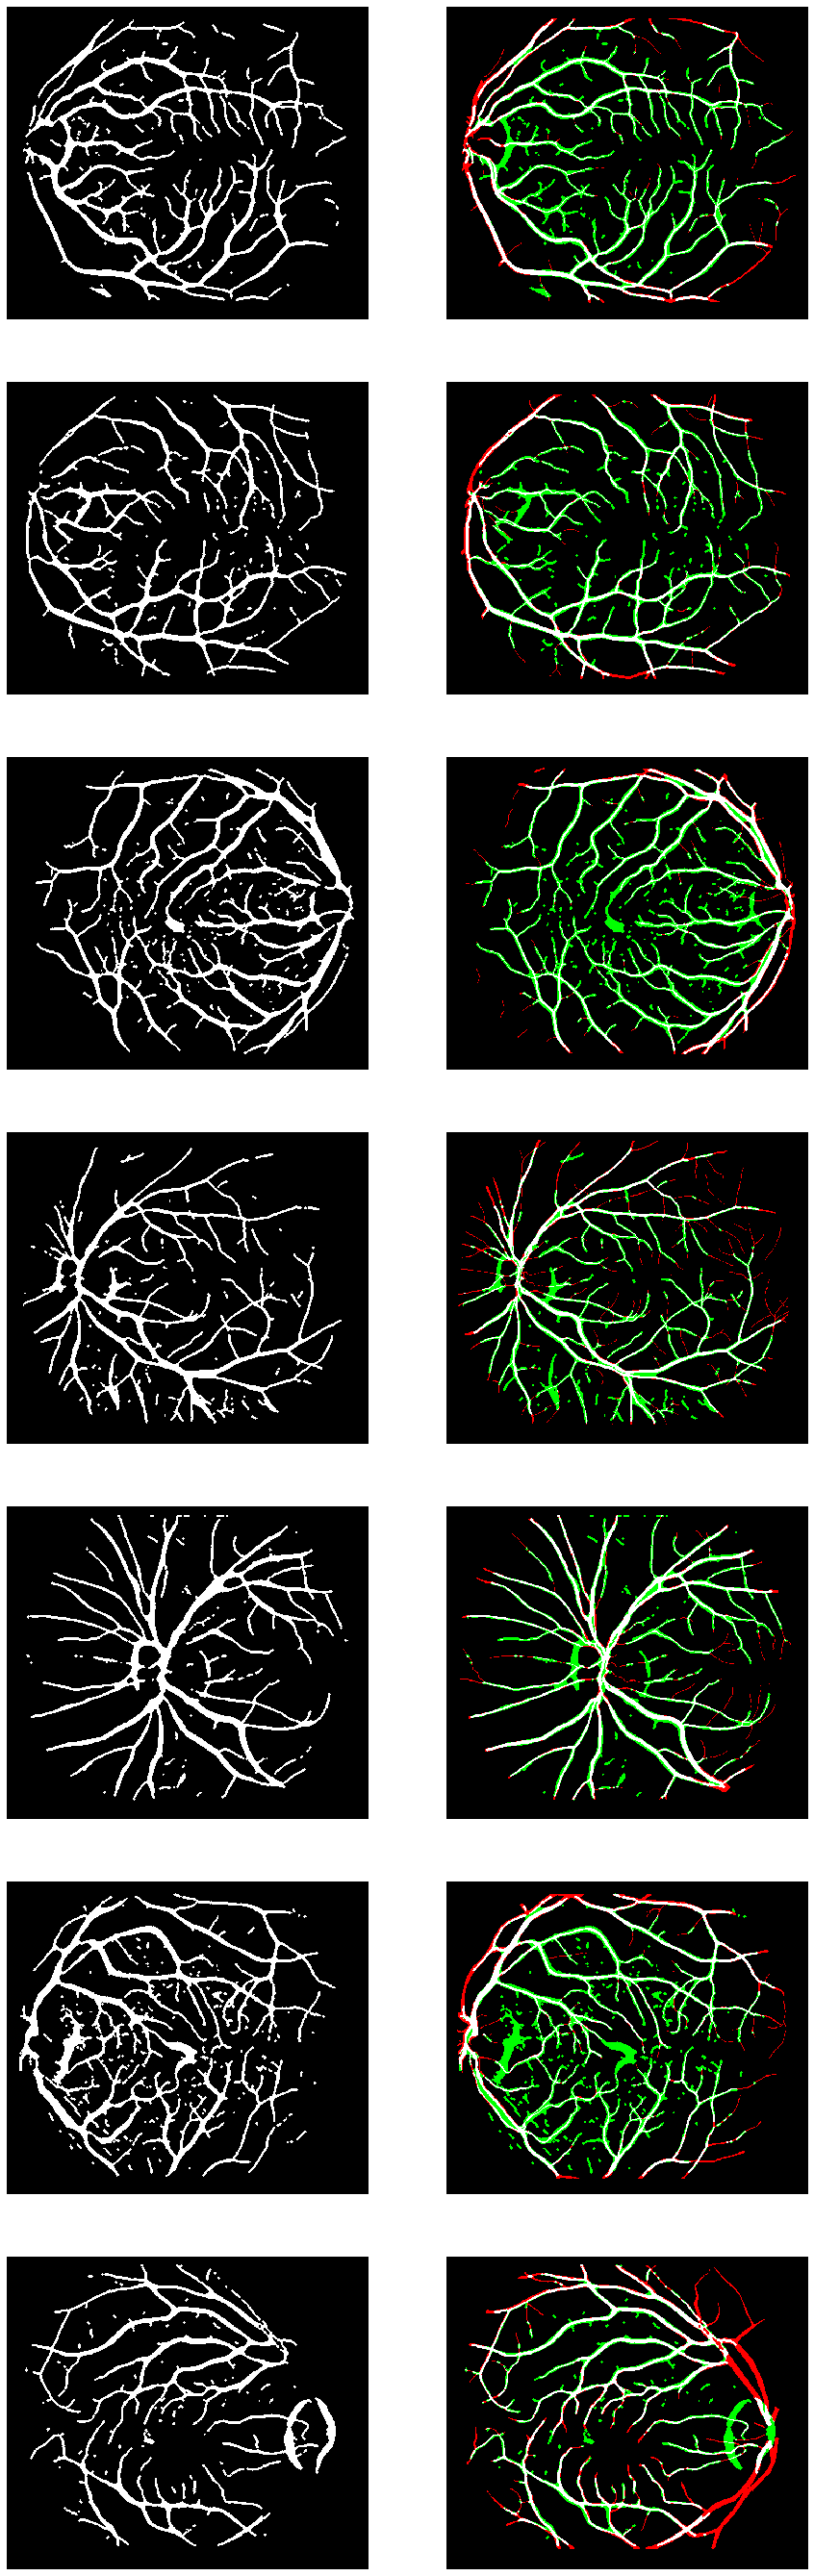

avgsensitivity 0.785438217577218
avgspecificity 0.9391461613069856


In [6]:
images = ['im0077', 'im0081', 'im0082', 'im0162', 'im0163', 'im0239', 'im0240']

columns = 2
rows = len(images)
fig=plt.figure(figsize=(15, rows * 7))
avgsensitivity=0.0
avgspecificity=0.0
for img in range(rows):
    
    original_image = plt.imread(folder + images[img] + in_img)
    
    processed_image = process_image(original_image)
    show_image(processed_image, [rows, columns, img*columns + 1])
    
    out_image = plt.imread(folder + images[img] + out_img)
    difi_image,sensitivity,accuracy,specificity=diffrence(processed_image,out_image)
    show_image(difi_image, [rows, columns, img*columns + 2])
    print("sensitivity",sensitivity)
    print("accuracy",accuracy)
    print("specificity",specificity)
    avgsensitivity+=sensitivity
    avgspecificity+=specificity
plt.show()
avgsensitivity=avgsensitivity/rows
print("avgsensitivity",avgsensitivity)
avgspecificity=avgspecificity/rows
print("avgspecificity",avgspecificity)



# KLASYFIKATOR KNN

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from scipy.stats import moment
import cv2

## Wstępne przetworzenie obrazu

In [17]:
def image_preprocessing(image):
    image = img_as_float(plt.imread(image))

    mask = rgb2gray(image)
    mask[mask > 0.15] = 1
    mask[mask <= 0.15] = 0
    mask = -mask
    mask = erosion(mask, disk(1))
    mask = dilation(mask, disk(5))
    mask = erosion(mask, disk(2))

    image = image[:,:,1]
    image = equalize_adapthist(image, clip_limit=0.02)
    
    image[mask == 0] = 0
    
    return image

## Wczytanie danych

In [18]:
folder = 'pictures/'
images = ['im0001', 'im0002', 'im0003', 'im0004', 'im0005', 'im0044', 'im0077', 'im0081',
          'im0082', 'im0139', 'im0162', 'im0163', 'im0235', 'im0236', 'im0239', 'im0240',
          'im0255', 'im0291', 'im0319', 'im0324']
in_img = '.ppm'
out_img = '.ah.ppm'

In [19]:
data_list = []
target_list = []

learn_images = images[:3]

for img in images:
    data_list += [image_preprocessing(folder + img + in_img)]
    target_list += [img_as_float(plt.imread(folder + img + out_img))]

## Ekstrakcja cech z obrazu

In [20]:
## funkcja zwracająca informacje o dzjęciach wykorzystanych do nauki
def features_labe_create(data_list, target_list):
    
    variance = []
    central_moment_3 = []
    central_moment_4 = []
    hu_moment = []
    target = []
    
    n = 5
    
    for image_data in data_list:
        x, y = image_data.shape
        for i in range(x // n):
            for j in range(y // n):
                img_data = image_data[n*i : n*(i+1), n*j : n*(j+1)].flatten()
                variance += [moment(img_data, moment = 2)]
                central_moment_3 += [moment(img_data, moment = 3)]
                central_moment_4 += [moment(img_data, moment = 4)]
                hu_moment += [cv2.HuMoments(cv2.moments(img_data))]
            
    for image_target in target_list:
        x, y = image_target.shape
        for i in range(x // n):
            for j in range(y // n):
                img_target = image_target[n*i : n*(i+1), n*j : n*(j+1)]
                target += [img_target[2,2]]
            
    return variance, central_moment_3, central_moment_4, target


## funkcja zwracająca informacje o zdjęciu, z którego chcemy wyodrębnić naczynia
def features_create(image_data):
    
    variance = []
    central_moment_3 = []
    central_moment_4 = []
    hu_moment = []
    
    n = 5
    
    x, y = image_data.shape
    for i in range(x // n):
        for j in range(y // n):
            img_data = image_data[n*i : n*(i+1), n*j : n*(j+1)].flatten()
            variance += [moment(img_data, moment = 2)]
            central_moment_3 += [moment(img_data, moment = 3)]
            central_moment_4 += [moment(img_data, moment = 4)]
            hu_moment += [cv2.HuMoments(cv2.moments(img_data))]
            
    return list(zip(variance, central_moment_3, central_moment_4))

## Klasyfikator

In [46]:
variance, central_moment_3, central_moment_4, target = features_labe_create(data_list, target_list)
features = list(zip(variance, central_moment_3, central_moment_4))
label = target

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3)

model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)

print("Zdolność predykcyjna:",metrics.accuracy_score(y_test, model.predict(X_test)))

Zdolność predykcyjna: 0.9368457300275482


## Segmentacja obrazu

Czułość -  0.3575158010442429
Trafność -  0.9383636363636364
Swoistość -  0.9870479514982764


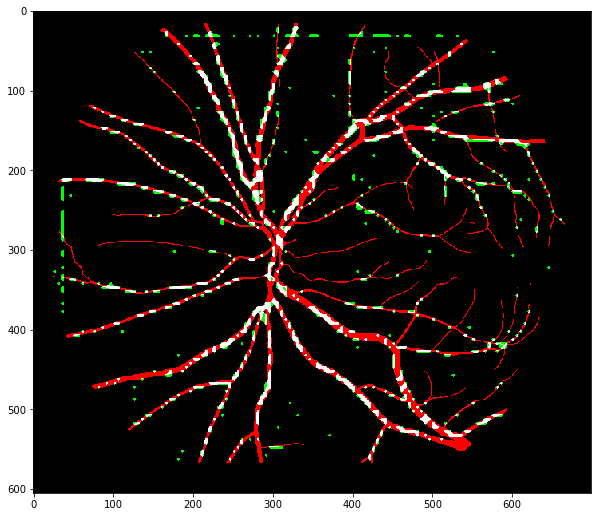

In [68]:
my_picture = image_preprocessing("pictures/im0163.ppm")
out_image = plt.imread("pictures/im0163.ah.ppm")
x, y = my_picture.shape
pct = features_create(my_picture)
predicted = model.predict(pct)
predicted = np.array_split(predicted, x//5)
predicted=np.stack(predicted, axis=0)
difi_image,sensitivity,accuracy,specificity=diffrence(predicted,out_image)
#print(predicted)
plt.figure(figsize=(10, 10))
#plt.imshow(predicted, cmap=plt.cm.gray)
plt.imshow(difi_image, cmap=plt.cm.gray)
print("Czułość - ",sensitivity)
print("Trafność - ",accuracy)
print("Swoistość - ",specificity)